<a href="https://www.kaggle.com/code/thanhngan123/segnet?scriptVersionId=231217533" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import lib**

In [10]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

# **Chuẩn bị tập dữ liệu**

In [20]:
# Đọc file Excel
file_path = '/kaggle/input/btxrd-data/classification.xlsx'
df = pd.read_excel(file_path)

# Hiển thị 20 dòng đầu tiên
df.head(20)

,image_id,center,age,gender,neoplasm,tumor_type,img_type,skeletal_type,bones_type,points,area,image_area,tumor_ratio,data_source
0,IMG000001.jpeg,1,48,F,malignant,other mt,frontal,pelvis,hip bone,"[[[2027.9285714285713, 1219.9285714285713], [2...",294967,7701561.0,3.83,train
1,IMG000002.jpeg,1,12,M,malignant,osteosarcoma,frontal,lower limb,tibia,"[[[895.6756756756756, 614.1981981981984], [895...",131041,4972480.0,2.64,train
2,IMG000003.jpeg,1,12,M,malignant,osteosarcoma,lateral,lower limb,tibia,"[[[811.7117117117116, 729.5135135135137], [831...",120650,6900832.0,1.75,train
3,IMG000004.jpeg,1,52,M,malignant,osteosarcoma,frontal,lower limb,foot,"[[[1302.6698113207547, 1734.9056603773583], [1...",91065,7214337.0,1.26,train
4,IMG000005.jpeg,1,52,M,malignant,osteosarcoma,oblique,lower limb,foot,"[[[1294.2446043165467, 1594.1870503597122], [1...",88469,7017152.0,1.26,train
5,IMG000006.jpeg,1,62,M,malignant,osteosarcoma,frontal,lower limb,femur,"[[[591.9130434782609, 1916.3043478260868], [47...",806550,5627824.0,14.33,train
6,IMG000007.jpeg,1,62,M,malignant,osteosarcoma,lateral,lower limb,femur,"[[[868.3636363636363, 420.45454545454544], [92...",592080,5172384.0,11.45,train
7,IMG000008.jpeg,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[585.0, 904.7058823529412], [577.35294117647...",61063,2650000.0,2.30,train
8,IMG000009.jpeg,1,6,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[671.6216216216216, 1090.9819819819818], [64...",49362,3085000.0,1.60,train
9,IMG000010.jpeg,1,16,M,malignant,osteosarcoma,frontal,upper limb,humerus,"[[[327.1296296296297, 1343.1604938271603], [36...",130881,4866640.0,2.69,train


In [ ]:
classification_file_path = '/kaggle/input/btxrd-data/classification.xlsx'
train_file_path = '/kaggle/input/btxrd-data/train.xlsx'
val_file_path = '/kaggle/input/btxrd-data/val.xlsx'

In [22]:
tumor_type_column = 'tumor_type'
source_col_name = 'data_source'

try:
    print(f"Đang đọc tệp: {classification_file_path}")
    df = pd.read_excel(classification_file_path)
    print(f"Đã đọc {len(df)} dòng.")

    required_cols = [tumor_type_column, source_col_name]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Lỗi: Tệp '{classification_file_path}' thiếu các cột cần thiết: {missing_cols}. "
                         f"Các cột có sẵn là: {list(df.columns)}. "
                         f"Hãy đảm bảo bạn đang đọc file Excel đã được thêm cột '{source_col_name}'.")

    # Thống kê số lượng theo tumor_type VÀ data_source 
    grouped_counts = df.groupby([tumor_type_column, source_col_name]).size()

    detailed_counts = grouped_counts.unstack(level=source_col_name, fill_value=0)

    if 'train' not in detailed_counts.columns:
        print("Cảnh báo: Không tìm thấy dữ liệu 'train' trong cột data_source. Thêm cột 'train' với giá trị 0.")
        detailed_counts['train'] = 0
    if 'test' not in detailed_counts.columns:
        print("Cảnh báo: Không tìm thấy dữ liệu 'test' trong cột data_source. Thêm cột 'test' với giá trị 0.")
        detailed_counts['test'] = 0

    # Tính cột tổng cộng
    detailed_counts['total'] = detailed_counts['train'] + detailed_counts['test']

    final_columns_order = [col for col in ['test', 'train', 'total'] if col in detailed_counts.columns]
    detailed_counts = detailed_counts[final_columns_order]

    print(detailed_counts.to_string())

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp tại đường dẫn '{classification_file_path}'.")
    print("Vui lòng kiểm tra lại đường dẫn. Nếu bạn đã lưu file vào /kaggle/working/, hãy sử dụng đường dẫn đó.")
except ValueError as e:
    # In lỗi cụ thể về việc thiếu cột
    print(e)
except Exception as e:
    print(f"Đã xảy ra lỗi không xác định khi xử lý tệp: {e}")

Đang đọc tệp: /kaggle/input/btxrd-data/classification.xlsx
Đã đọc 3746 dòng.
data_source               test  train  total
tumor_type                                  
giant cell tumor            20     73     93
multiple osteochondromas    66    197    263
osteochondroma             138    616    754
osteofibroma                14     30     44
osteosarcoma                53    244    297
other bt                    22     93    115
other mt                    11     34     45
simple bone cyst            37    169    206
synovial osteochondroma     13     37     50


In [ ]:
# Đường dẫn 


nháp

In [30]:
from keras import models
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Reshape, Permute, Dropout, Flatten, Dense
from keras.optimizers import Adam
import os, numpy as np, matplotlib.pyplot as plt, json, cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import random, shutil

import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

from collections import defaultdict

# **1) Chuẩn hóa dữ liệu**

Dataset btxrd-v2
- Giảm kích thước ảnh: scale = 0.5
- Chuẩn hóa ảnh thành hình vuông 2440x2440
- Cập nhật lại points

In [23]:
image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images" 

# Biến lưu kích thước min & max
min_width, min_height = float('inf'), float('inf')
max_width, max_height = 0, 0

# Lặp qua tất cả ảnh
for file in os.listdir(image_dir):
    if file.endswith(('.png', '.jpg', '.jpeg')):
        img = cv2.imread(os.path.join(image_dir, file))
        h, w, _ = img.shape  # Lấy chiều cao & chiều rộng

        # Cập nhật kích thước nhỏ nhất
        min_width, min_height = min(min_width, w), min(min_height, h)

        # Cập nhật kích thước lớn nhất
        max_width, max_height = max(max_width, w), max(max_height, h)

print(f"Kích thước nhỏ nhất: {min_width} x {min_height}")
print(f"Kích thước lớn nhất: {max_width} x {max_height}")

Kích thước nhỏ nhất: 153 x 311
Kích thước lớn nhất: 3594 x 4881


In [24]:
from tqdm import tqdm

image_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/images"
annotation_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations"

output_dir = "/kaggle/working/btxrd-data2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

SCALE_FACTOR = 0.2
TARGET_SIZE = 976

# Lấy danh sách file ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Xử lý từng ảnh
for file in tqdm(image_files, desc="Processing images & annotations"):
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit('.', 1)[0] + '.json')

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
    if img is None:
        print(f"⚠ Không thể đọc ảnh: {file}")
        continue

    orig_height, orig_width = img.shape[:2]

    # Resize ảnh
    new_width = int(orig_width * SCALE_FACTOR)
    new_height = int(orig_height * SCALE_FACTOR)
    img_resized = cv2.resize(img, (new_width, new_height))

    # Tính toán padding
    top = (TARGET_SIZE - new_height) // 2
    bottom = TARGET_SIZE - new_height - top
    left = (TARGET_SIZE - new_width) // 2
    right = TARGET_SIZE - new_width - left

    # Thêm padding vào ảnh
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Lưu ảnh sau khi scale & padding
    output_img_path = os.path.join(output_image_dir, file)
    cv2.imwrite(output_img_path, padded_img)

    # Nếu có annotation thì cập nhật và lưu lại
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)

        # Cập nhật annotation (scale & padding)
        for shape in annotation["shapes"]:
            new_points = []
            for x, y in shape["points"]:
                # Scale tọa độ
                x = x * SCALE_FACTOR
                y = y * SCALE_FACTOR
                # Padding tọa độ
                x = x + left
                y = y + top
                new_points.append([x, y])

            shape["points"] = new_points  # Cập nhật điểm mới

        # Cập nhật kích thước ảnh trong annotation
        annotation["imageWidth"] = TARGET_SIZE
        annotation["imageHeight"] = TARGET_SIZE

        # Lưu annotation mới
        output_annotation_path = os.path.join(output_anno_dir, file.rsplit('.', 1)[0] + '.json')
        with open(output_annotation_path, "w", encoding="utf-8") as f:
            json.dump(annotation, f, indent=4)

print(f"\nHoàn thành! Ảnh và annotation đã lưu tại: {output_dir}")


Processing images & annotations: 100%|██████████| 3746/3746 [00:57<00:00, 65.31it/s]


Hoàn thành! Ảnh và annotation đã lưu tại: /kaggle/working/btxrd-data2


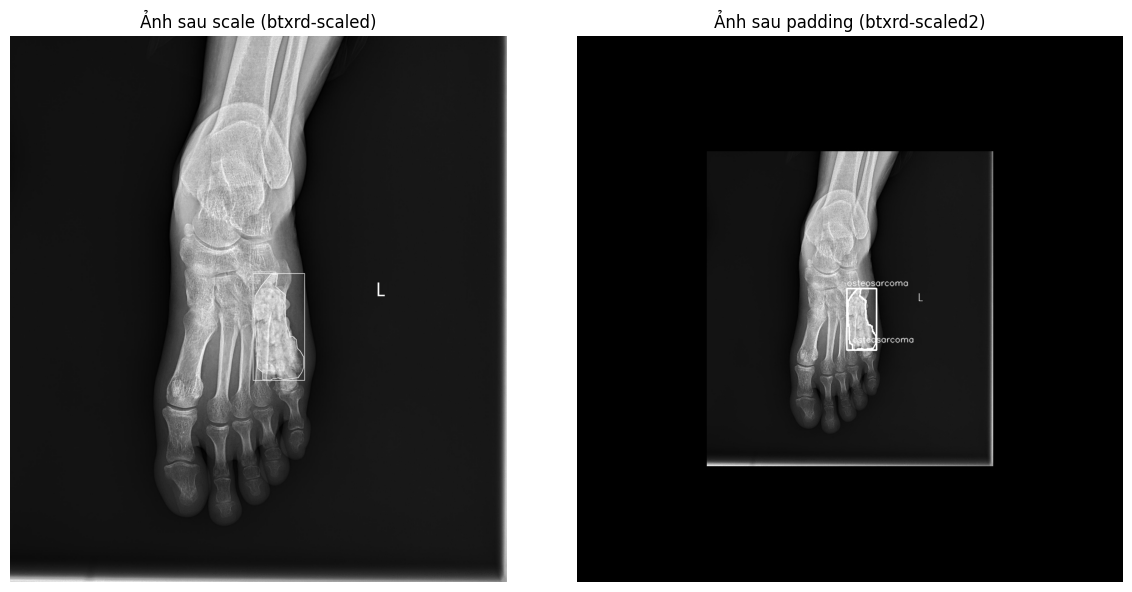


Hoàn thành kiểm tra ảnh!


In [27]:
image_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/images", "/kaggle/working/btxrd-data2/images"]
anno_dirs = ["/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations", "/kaggle/working/btxrd-data2/Annotations"]

# Tên ảnh cần kiểm tra
image_name = "IMG000004.jpeg"

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Ảnh sau scale (btxrd-scaled)", "Ảnh sau padding (btxrd-scaled2)"]

for i in range(2):
    img_path = os.path.join(image_dirs[i], image_name)
    anno_path = os.path.join(anno_dirs[i], image_name.replace('.jpeg', '.json'))

    # Đọc ảnh
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠ Không tìm thấy ảnh: {img_path}")
        continue

    # Đọc annotation nếu tồn tại
    if os.path.exists(anno_path):
        with open(anno_path, 'r', encoding='utf-8') as f:
            annotation = json.load(f)

        for shape in annotation.get("shapes", []):
            points = shape["points"]
            label = shape.get("label", "")

            if shape["shape_type"] == "polygon":
                # Vẽ đường bao vùng ung thư (đa giác) màu đỏ
                pts = np.array(points, np.int32).reshape((-1, 1, 2))
                cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)

                # Vẽ nhãn màu đỏ
                x, y = int(points[0][0]), int(points[0][1])
                cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

            elif shape["shape_type"] == "rectangle":
                # Vẽ hình chữ nhật vùng ung thư màu đỏ
                x1, y1 = map(int, points[0])
                x2, y2 = map(int, points[1])
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

                # Vẽ nhãn màu đỏ
                cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(titles[i])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

print("\nHoàn thành kiểm tra ảnh!")


# **2) Chia tập dữ liệu**

Dataset btxrd-v3: tách btxrd-v2 thành 3 phần train, test, valid
   + train: 70%
   + valid: 10%
   + test: 20%

In [28]:
# Đường dẫn 
image_dir = "/kaggle/working/btxrd-data2/images"
annotation_dir = "/kaggle/working/btxrd-data2/Annotations"

output_base = "/kaggle/working/BTXRD_v3"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
valid_dir = os.path.join(output_base, "valid")

In [6]:
# # Tạo thư mục lưu ảnh mới
# for folder in [train_dir, test_dir, valid_dir]:
#     os.makedirs(os.path.join(folder, "images"), exist_ok=True)
#     os.makedirs(os.path.join(folder, "Annotations"), exist_ok=True)

# # Lấy danh sách ảnh
# image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
# random.shuffle(image_files)

# # Tính số lượng ảnh cho mỗi tập
# total = len(image_files)
# train_split = int(0.7 * total)
# test_split = int(0.2 * total)

# # Chia danh sách ảnh
# train_files = image_files[:train_split]
# test_files = image_files[train_split:train_split + test_split]
# valid_files = image_files[train_split + test_split:]

# # Hàm di chuyển ảnh và annotation tương ứng
# def move_files(files, dest_folder):
#     for file in files:
#         # Di chuyển ảnh
#         shutil.copy(os.path.join(image_dir, file), os.path.join(dest_folder, "images", file))

#         # Di chuyển file annotation nếu có
#         annotation_file = file.replace(file.split('.')[-1], 'json')  # Đổi đuôi thành .json
#         if os.path.exists(os.path.join(annotation_dir, annotation_file)):
#             shutil.copy(os.path.join(annotation_dir, annotation_file), os.path.join(dest_folder, "Annotations", annotation_file))

# # Di chuyển các tập dữ liệu
# move_files(train_files, train_dir)
# move_files(test_files, test_dir)
# move_files(valid_files, valid_dir)

# print(f"Đã chia {total} ảnh thành:")
# print(f"- Train: {len(train_files)} ảnh")
# print(f"- Test: {len(test_files)} ảnh")
# print(f"- Valid: {len(valid_files)} ảnh")


Đã chia 3746 ảnh thành:
- Train: 2622 ảnh
- Test: 749 ảnh
- Valid: 375 ảnh


In [32]:
splits = {"train": train_dir, "valid": valid_dir, "test": test_dir}
for split, path in splits.items():
    os.makedirs(os.path.join(path, "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "Annotations"), exist_ok=True)

# Lấy danh sách ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith((".png", ".jpg", ".jpeg"))]
random.shuffle(image_files)  # Xáo trộn để tránh bias

# Nhóm ảnh theo label (dành cho ảnh có khối u)
label_groups = defaultdict(list)
no_tumor_images = []

for file in image_files:
    img_path = os.path.join(image_dir, file)
    anno_path = os.path.join(annotation_dir, file.rsplit(".", 1)[0] + ".json")
    
    if os.path.exists(anno_path):
        with open(anno_path, "r", encoding="utf-8") as f:
            annotation = json.load(f)
        
        labels = set(shape["label"] for shape in annotation["shapes"])
        for label in labels:
            label_groups[label].append(file)
    else:
        no_tumor_images.append(file)

# Hàm chia dữ liệu
def split_data(files, train_ratio=0.7, valid_ratio=0.2):
    n = len(files)
    n_train = int(n * train_ratio)
    n_valid = int(n * valid_ratio)
    
    train_set = files[:n_train]
    valid_set = files[n_train:n_train + n_valid]
    test_set = files[n_train + n_valid:]
    
    return train_set, valid_set, test_set

# Chia ảnh có khối u
train_files, valid_files, test_files = [], [], []
for label, files in label_groups.items():
    random.shuffle(files)
    train, valid, test = split_data(files)
    train_files.extend(train)
    valid_files.extend(valid)
    test_files.extend(test)

# Chia ảnh không có khối u
train_no_tumor, valid_no_tumor, test_no_tumor = split_data(no_tumor_images)
train_files.extend(train_no_tumor)
valid_files.extend(valid_no_tumor)
test_files.extend(test_no_tumor)

# Copy file vào thư mục mới
def copy_files(file_list, split):
    for file in file_list:
        shutil.copy(os.path.join(image_dir, file), os.path.join(splits[split], "images", file))
        anno_path = os.path.join(annotation_dir, file.rsplit(".", 1)[0] + ".json")
        if os.path.exists(anno_path):
            shutil.copy(anno_path, os.path.join(splits[split], "Annotations", os.path.basename(anno_path)))

copy_files(train_files, "train")
copy_files(valid_files, "valid")
copy_files(test_files, "test")

print(f"Chia dữ liệu hoàn tất!\nTrain: {len(train_files)}\nValid: {len(valid_files)}\nTest: {len(test_files)}")


Chia dữ liệu hoàn tất!
Train: 2618
Valid: 745
Test: 383


# **3) Xây dựng mô hình CNN**

In [33]:
n_classes = 2     # normal, tumor
IMG_SIZE = 976

In [34]:
# Đường dẫn dữ liệu
data_dir = '/kaggle/working/BTXRD_v3'
train_images_dir = os.path.join(data_dir, "train", "images")
train_annotations_dir = os.path.join(data_dir, "train", "Annotations")
valid_images_dir = os.path.join(data_dir, "valid", "images")
valid_annotations_dir = os.path.join(data_dir, "valid", "Annotations")
test_images_dir = os.path.join(data_dir, "test", "images")
test_annotations_dir = os.path.join(data_dir, "test", "Annotations")

In [35]:
INPUT_SHAPE = (976, 976, 1)

# eccoder
inputs = layers.Input(shape=INPUT_SHAPE)

# Block 1
x = layers.Conv2D(32, (3,3), strides=2, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip1 = x 

# Block 2
x = layers.Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip2 = x  

# Block 3
x = layers.Conv2D(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
skip3 = x  

# Block 4
x = layers.Conv2D(256, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
# skip4 = x  

# # Bottleneck
# x = layers.Conv2D(512, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

In [36]:
# Decoder
# # Block 5
# x = layers.Conv2DTranspose(256, (3,3), strides=2, padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Resizing(skip4.shape[1], skip4.shape[2])(x)
# x = layers.Concatenate()([x, skip4])
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.BatchNormalization()(x)

# Block 4
x = layers.Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip3.shape[1], skip3.shape[2])(x)
x = layers.Concatenate()([x, skip3])
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 3
x = layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip2.shape[1], skip2.shape[2])(x)
x = layers.Concatenate()([x, skip2])
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 2
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Resizing(skip1.shape[1], skip1.shape[2])(x)
x = layers.Concatenate()([x, skip1])
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

# Block 1 (Khôi phục kích thước gốc)
x = layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)

outputs = layers.Conv2D(n_classes, (1,1), activation='softmax')(x)


In [37]:
# Compile mô hình
model = models.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Hiển thị cấu trúc mô hình
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 976, 976, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 488, 488, 32)   │            320 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 488, 488, 32)   │            128 │ conv2d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 488, 488, 32)   │          9,248 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 488, 488, 32)   │            128 │ conv2d_13[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 244, 244, 64)   │         18,496 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 244, 244, 64)   │            256 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 244, 244, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 244, 244, 64)   │            256 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 122, 122, 128)  │         73,856 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 122, 122, 128)  │            512 │ conv2d_16[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 122, 122, 128)  │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 122, 122, 128)  │            512 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 61, 61, 256)    │        295,168 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 61, 61, 256)    │          1,024 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)   

 Total params: 1,961,346 (7.48 MB)

 Trainable params: 1,958,466 (7.47 MB)

 Non-trainable params: 2,880 (11.25 KB)

# **4) Huấn luyện mô hình**

In [40]:
def data_generator(image_dir, annotation_dir, img_size=IMG_SIZE, num_classes=2, batch_size=16):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    while True:  # Generator chạy liên tục
        np.random.shuffle(image_files)  # Xáo trộn ảnh mỗi epoch
        
        for i in range(0, len(image_files), batch_size):
            batch_files = image_files[i:i + batch_size]

            X_batch, y_batch = [], []
            
            for file in batch_files:
                img_path = os.path.join(image_dir, file)
                annotation_path = os.path.join(annotation_dir, file.replace(file.split('.')[-1], 'json'))
                
                # Đọc ảnh
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Đọc ảnh grayscale
                if img is None:
                    continue
                
                img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
                img = img.astype(np.float32) / 255.0  # Giảm bộ nhớ với float32
                
                # Khởi tạo mask mặc định là background (0)
                mask = np.zeros((img_size, img_size), dtype=np.uint8)
                
                if os.path.exists(annotation_path):
                    with open(annotation_path, "r") as f:
                        annotation = json.load(f)

                    for shape in annotation.get("shapes", []):
                        points = np.array(shape["points"], np.int32)
                        if "imageWidth" in annotation:
                            points = (points * img_size / annotation["imageWidth"]).astype(np.int32)
                            cv2.fillPoly(mask, [points], 1)

                # One-hot encoding mask
                mask = to_categorical(mask, num_classes=num_classes).astype(np.float32)

                X_batch.append(np.expand_dims(img, axis=-1))  # Thêm chiều kênh (1)
                y_batch.append(mask)

            yield np.array(X_batch), np.array(y_batch)  # Trả về batch nhỏ

In [41]:
# Tạo generator
batch_size = 8
train_generator = data_generator(train_images_dir, train_annotations_dir, batch_size=batch_size)
valid_generator = data_generator(valid_images_dir, valid_annotations_dir, batch_size=batch_size)

# Load thử 1 batch để kiểm tra
X_batch, y_batch = next(train_generator)
print(f"Batch Shape: X: {X_batch.shape}, y: {y_batch.shape}")

Batch Shape: X: (8, 976, 976, 1), y: (8, 976, 976, 2)


In [42]:
# Compile mô hình
# Hàm IoU (Intersection over Union)
def iou_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

model.compile(optimizer=Adam(learning_rate=1e-4),  # Learning rate nhỏ để ổn định training
              loss=CategoricalCrossentropy(),  # Hàm mất mát phù hợp với phân loại đa lớp
              metrics=["accuracy", iou_metric])  # Thêm IoU để theo dõi

In [43]:
# Callback giảm learning rate nếu val_loss không cải thiện
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# Callback lưu mô hình tốt nhất trong quá trình train
checkpoint = ModelCheckpoint("unet_v1.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Số batch mỗi epoch (số ảnh chia cho batch_size)
steps_per_epoch = len(os.listdir(train_images_dir)) // batch_size
validation_steps = len(os.listdir(valid_images_dir)) // batch_size

starting_time = time.time()

# Huấn luyện mô hình với generator
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50, 
    steps_per_epoch=steps_per_epoch,  
    validation_steps=validation_steps,  
    callbacks=[checkpoint, reduce_lr]
)
print('> Training time is %.4f minutes' % ((time.time() - starting_time) / 60))

Epoch 1/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.7341 - iou_metric: 0.6144 - loss: 0.7014
Epoch 1: val_loss improved from inf to 0.52087, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 192s 528ms/step - accuracy: 0.7345 - iou_metric: 0.6150 - loss: 0.7011 - val_accuracy: 0.9934 - val_iou_metric: 0.9868 - val_loss: 0.5209 - learning_rate: 1.0000e-04
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9951 - iou_metric: 0.9902 - loss: 0.4532
Epoch 2: val_loss improved from 0.52087 to 0.31060, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 156s 476ms/step - accuracy: 0.9951 - iou_metric: 0.9903 - loss: 0.4530 - val_accuracy: 0.9985 - val_iou_metric: 0.9970 - val_loss: 0.3106 - learning_rate: 1.0000e-04
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9984 - iou_metric: 0.9967 - loss: 0.2764
Epoch 3: val_loss improved from 0.31060 to 0.18659, saving model to unet_v1.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 154s 473ms/s

# **5) Đánh giá mô hình**

Dựa trên MeanIoU, Dice Coefficent và kiểm tra trên tập test

In [44]:
# Load tập dữ liệu test
test_generator = data_generator(test_images_dir, test_annotations_dir, batch_size=1)

# Lấy một batch test
X_test, y_test = next(test_generator)

# Dự đoán bằng mô hình
y_pred = model.predict(X_test)

# Chuyển về dạng nhãn (bỏ one-hot encoding)
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(y_pred, axis=-1)

def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)  # Vùng giao
    union = np.logical_or(y_true, y_pred)  # Vùng hợp
    return np.sum(intersection) / (np.sum(union) + 1e-6)  # Tránh chia cho 0

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + epsilon)  # Tránh chia cho 0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [46]:
num_tumor_pred = 0
num_normal_pred = 0

for X_test, y_test in test_generator:
    y_pred = model.predict(X_test, verbose=0)

    y_true = np.argmax(y_test, axis=-1)
    y_pred = np.argmax(y_pred, axis=-1)

    iou = iou_score(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)

    iou_scores.append(iou)
    dice_scores.append(dice)

    # Đếm số ảnh dự đoán là tumor hoặc normal
    if np.any(y_pred == 1):  # Nếu có bất kỳ điểm nào được dự đoán là tumor
        num_tumor_pred += 1
    else:
        num_normal_pred += 1

    total_images += 1
    if total_images >= total_images_in_test:  # Dừng khi đã xử lý đủ ảnh
        break

# Tính giá trị trung bình trên toàn bộ tập test
mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)

print(f"Predicted Tumor Images: {num_tumor_pred}")
print(f"Predicted Normal Images: {num_normal_pred}")
print(f"Mean IoU on test set: {mean_iou:.4f}")
print(f"Mean Dice Score on test set: {mean_dice:.4f}")


Predicted Tumor Images: 1
Predicted Normal Images: 0
Mean IoU on test set: 0.0220
Mean Dice Score on test set: 0.0347


In [47]:
num_tumor_pred_pixels = np.sum(y_pred == 1)
print(f"Total predicted tumor pixels: {num_tumor_pred_pixels}")


Total predicted tumor pixels: 101


In [48]:
num_tumor_pixels = np.sum(y_true == 1)
print(f"Total tumor pixels in ground truth: {num_tumor_pixels}")


Total tumor pixels in ground truth: 1275


In [49]:
print("Unique values in y_true:", np.unique(y_true))
print("Unique values in y_pred:", np.unique(y_pred))


Unique values in y_true: [0 1]
Unique values in y_pred: [0 1]


khúc này trở xuống chưa chạy đc

In [ ]:
# kiểm tra một ảnh đơn lẻ
# này đang lỗi (chưa nhận diện được khối u)

def predict_single_image(image_path, model):
    # Đọc và xử lý ảnh giống như trong load_data
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_h, img_w))
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều kênh
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension (1, img_h, img_w, 1)
    
    # Dự đoán
    prediction = model.predict(img)
    
    # Kết quả
    class_idx = np.argmax(prediction)  # Chọn lớp có xác suất cao nhất
    if class_idx == 1:
        print("Ảnh này có khả năng chứa khối u / ung thư.")
    else:
        print("Ảnh này không có khối u / ung thư.")
    
    return prediction

# Chạy thử một ảnh
test_image_path = '/kaggle/input/btxrd-v2/test/images/IMG000005.jpeg'
predict_single_image(test_image_path, model)
